# Image Classification of ATLAS Calorimeter Topo-Clusters

This notebook includes performance comparisons of different Machine Learning techniques for classifying topological clusters in the ATLAS calorimeter. 

### The task

Train a classifier to determine which type of particle generated the parton showers in the cluster (e.g. $e^{\pm}$ vs. $\pi^{\pm}$ or $\pi^0$ vs. $\pi^{\pm}$).

### The cluster images

Each cluster is associated with six 2D images, corresponding to the barrels layers of the EM (EMB1, EMB2, EMB3) and HAD (TileBar0, TileBar2, TileBar3) calorimeters. Normalized calorimeter cell energies are used as pixel values. The image size is $0.4\times0.4$ in $\eta\times\phi$ space.

The following models are implemented:

1. Simple fully-connected Neural Network (flattening the images and only using the 512 pixels in the EMB1 layer).
2. Convolutional Neural Networks using only one layer (preserving the shape of the 2D images).
3. A network with multiple images as inputs, and one output (first couple of ConvNets are trained separately, then flattened and concatenated). 

TODO
- Cleanup code a bit, in particular make it easier to swap samples.
- Probably modify inputs to be just numpy arrays (rather than a dictionary of arrays), makes it easier to slice and dice inputs. 
- Implement a network of concatenated ConvNets taking all calorimeter layer images into account.
- Also compare the performance with other ML algorithms; logistic regression, SVD, Naive Bias, Gaussians, etc.


In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

# metadata
layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
len_phi = [4, 16, 16, 4, 4, 4]
len_eta = [128, 16, 8, 4, 4, 2]

## Import the datasets 

The notebook is structured to make the swapping of datasets trivial. 

In [2]:
# import electron vs. pion images (pt = 100 GeV)

elec = np.load("../datasets/images_electron_100_v01-4-g1135c42.npz")
pion = np.load("../datasets/images_pion_100_v01-4-g1135c42.npz")

nelec = len(elec['EMB1'])
npion = len(pion['EMB1'])
print("Number of electron events: {}".format(nelec))
print("Number of pion events: {}".format(npion))
print("Total: {}".format(nelec+npion))

Number of electron events: 11741
Number of pion events: 10968
Total: 22709


In [3]:
# import pi+- vs. pi0 images

#nmax = 20000
# TODO fix input files so that it is easier to split up the events
p0 = np.load("../datasets/images_pi0_v01-6-g20e4c51.npz")
pp = np.load("../datasets/images_piplus_v01-6-g20e4c51.npz")
pm = np.load("../datasets/images_piminus_v01-6-g20e4c51.npz")

np0 = len(p0['EMB1'])
npp = len(pp['EMB1'])
npm = len(pm['EMB1'])

print("Number of pi0 events: {}".format(np0))
print("Number of pi+ events: {}".format(npp))
print("Number of pi- events: {}".format(npm))
print("Total: {}".format(np0+npp+npm))

Number of pi0 events: 325485
Number of pi+ events: 78634
Number of pi- events: 77287
Total: 481406


### Plot a few example images

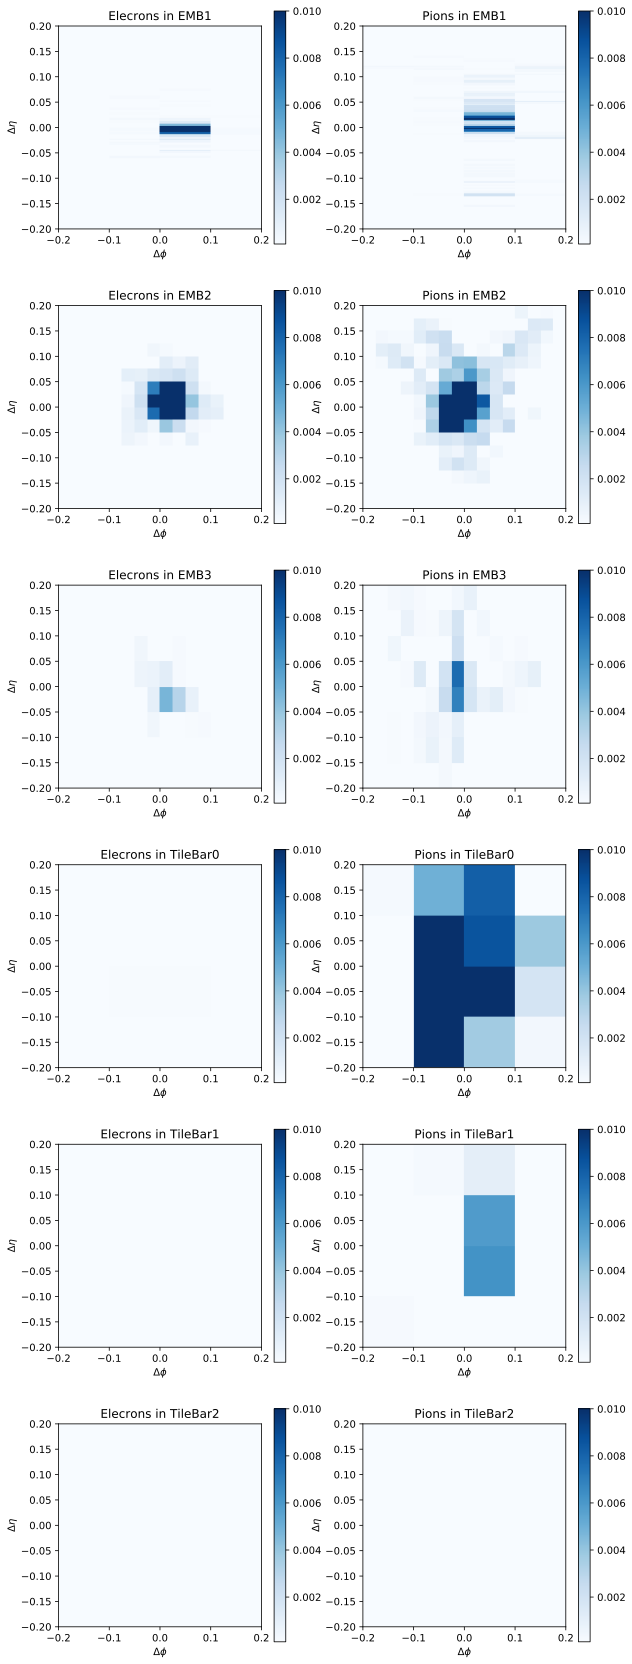

In [4]:
# plots for pT = 100 GeV electron/pion samples

from matplotlib.colors import Normalize, LogNorm

# specify which cluster to plot
cluster = 150

# make the plot
plt.cla(); plt.clf()
plt.figure(figsize=(10,30))

i = 1
for layer in layers:
    
    # electrons
    plt.subplot(6,2,i)
    i += 1
    plt.imshow(elec[layer][cluster], extent=[-0.2, 0.2, -0.2, 0.2],
               cmap=plt.get_cmap('Blues'), origin='lower', interpolation='nearest', norm=Normalize(vmin=0.0001, vmax=0.01))
    plt.colorbar()
    plt.title('Elecrons in {}'.format(layer))
    plt.xlabel("$\Delta\phi$")
    plt.ylabel("$\Delta\eta$")

    # charged pions
    plt.subplot(6,2,i)
    i += 1
    plt.imshow(pion[layer][cluster], extent=[-0.2, 0.2, -0.2, 0.2],
               cmap=plt.get_cmap('Blues'), origin='lower', interpolation='nearest', norm=Normalize(vmin=0.0001, vmax=0.01))
    plt.colorbar()
    plt.title('Pions in {}'.format(layer))
    plt.xlabel("$\Delta\phi$")
    plt.ylabel("$\Delta\eta$")

# show the plots
plt.show()
#plt.savefig('plots_pion_electron.pdf')

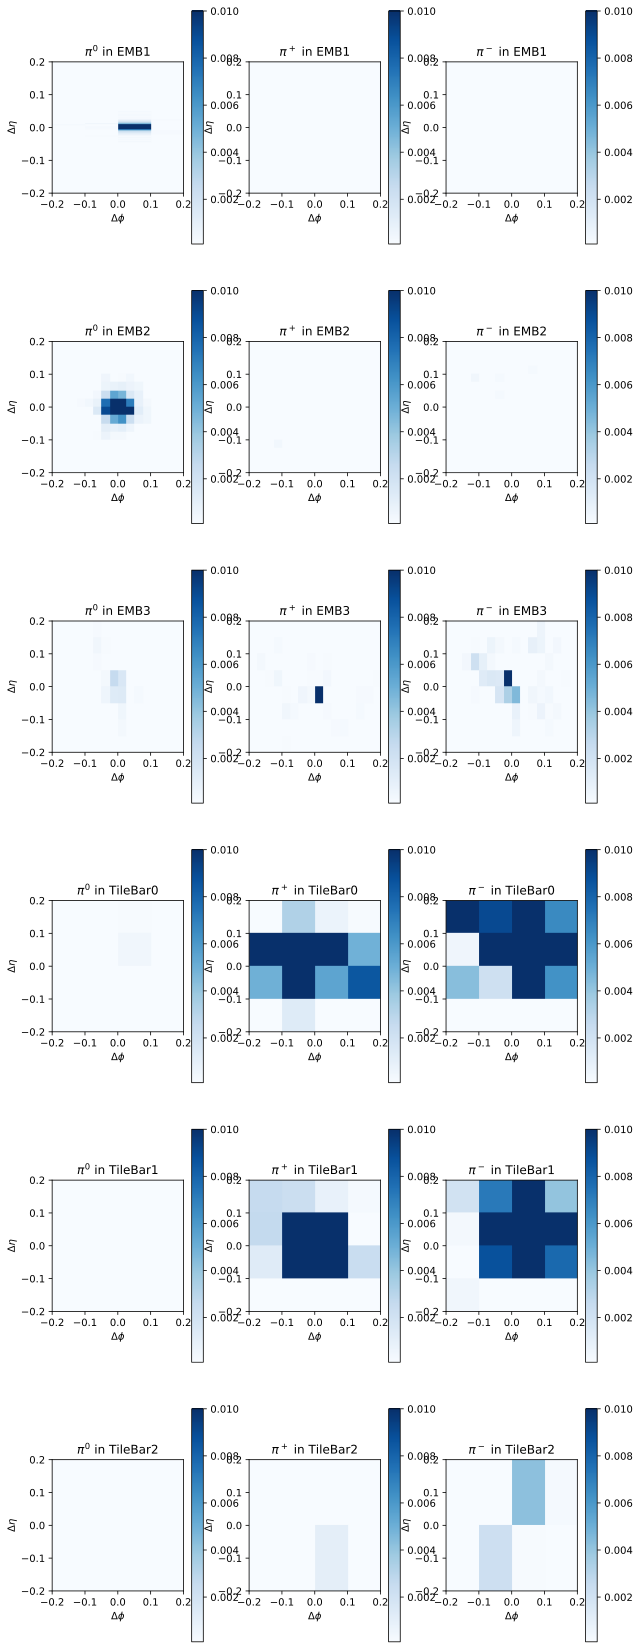

In [5]:
# plots for E = 0.5-2000 GeV pi0/pi+/pi- samples

from matplotlib.colors import Normalize, LogNorm

# specify which cluster to plot
cluster = 0

# make the plot
plt.cla(); plt.clf()
plt.figure(figsize=(10,30))

i = 1
for layer in layers:
    
    # pi0
    plt.subplot(6,3,i)
    i += 1
    plt.imshow(p0[layer][cluster], extent=[-0.2, 0.2, -0.2, 0.2],
               cmap=plt.get_cmap('Blues'), origin='lower', interpolation='nearest', norm=Normalize(vmin=0.0001, vmax=0.01))
    plt.colorbar()
    plt.title('$\pi^0$ in {}'.format(layer))
    plt.xlabel("$\Delta\phi$")
    plt.ylabel("$\Delta\eta$")

    # pi+
    plt.subplot(6,3,i)
    i += 1
    plt.imshow(pp[layer][cluster], extent=[-0.2, 0.2, -0.2, 0.2],
               cmap=plt.get_cmap('Blues'), origin='lower', interpolation='nearest', norm=Normalize(vmin=0.0001, vmax=0.01))
    plt.colorbar()
    plt.title('$\pi^+$ in {}'.format(layer))
    plt.xlabel("$\Delta\phi$")
    plt.ylabel("$\Delta\eta$")
    
    # pi-
    plt.subplot(6,3,i)
    i += 1
    plt.imshow(pm[layer][cluster], extent=[-0.2, 0.2, -0.2, 0.2],
               cmap=plt.get_cmap('Blues'), origin='lower', interpolation='nearest', norm=Normalize(vmin=0.0001, vmax=0.01))
    plt.colorbar()
    plt.title('$\pi^-$ in {}'.format(layer))
    plt.xlabel("$\Delta\phi$")
    plt.ylabel("$\Delta\eta$")

# show the plots
plt.show()
#plt.savefig('plots_pi0_plus_minus.pdf')

### Plot a few histograms

/usr/local/lib/python2.7/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


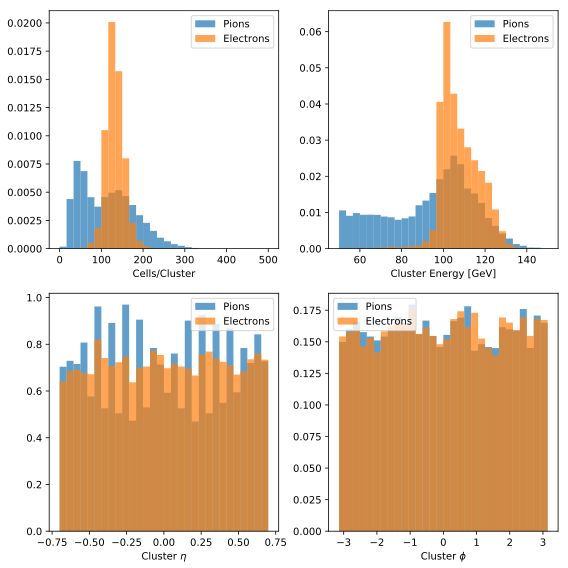

In [6]:
# histograms for pT = 100 GeV electron/pion samples

n_bins=30

plt.cla(); plt.clf()
fig, ax = plt.subplots(2, 2, tight_layout=True, figsize=(8,8))

# number of cells per cluster
ax[0,0].hist(pion['cluster_nCells'], bins=n_bins, normed=True, range=(0,500), alpha=0.7, label='Pions')
ax[0,0].hist(elec['cluster_nCells'], bins=n_bins, normed=True, range=(0,500), alpha=0.7, label='Electrons')
ax[0,0].set_xlabel('Cells/Cluster')
ax[0,0].legend()

# cluster energy
ax[0,1].hist(pion['clusterE'], bins=n_bins, normed=True, range=(50,150), alpha=0.7, label='Pions')
ax[0,1].hist(elec['clusterE'], bins=n_bins, normed=True, range=(50,150), alpha=0.7, label='Electrons')
ax[0,1].set_xlabel('Cluster Energy [GeV]')
ax[0,1].legend()

# cluster pseudo-rapidity, eta = -ln(tan(theta/2))
ax[1,0].hist(pion['clusterEta'], bins=n_bins, normed=True, alpha=0.7, label='Pions')
ax[1,0].hist(elec['clusterEta'], bins=n_bins, normed=True, alpha=0.7, label='Electrons')
ax[1,0].set_xlabel('Cluster $\eta$')
ax[1,0].legend()

# cluster azimuthal angle 
ax[1,1].hist(pion['clusterPhi'], bins=n_bins, normed=True, alpha=0.7, label='Pions')
ax[1,1].hist(elec['clusterPhi'], bins=n_bins, normed=True, alpha=0.7, label='Electrons')
ax[1,1].set_xlabel('Cluster $\phi$')
ax[1,1].legend()

plt.show()
#plt.savefig('hist_pion_electron.pdf')

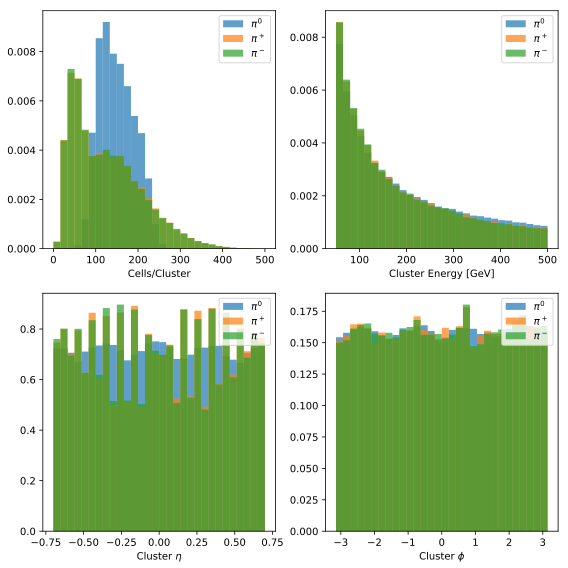

In [7]:
# histograms for E = 0.5-2000 GeV pi0/pi+/pi- samples

n_bins=30

plt.cla(); plt.clf()
fig, ax = plt.subplots(2, 2, tight_layout=True, figsize=(8,8))

# number of cells per cluster
ax[0,0].hist(p0['cluster_nCells'], bins=n_bins, normed=True, range=(0,500), alpha=0.7, label='$\pi^0$')
ax[0,0].hist(pp['cluster_nCells'], bins=n_bins, normed=True, range=(0,500), alpha=0.7, label='$\pi^+$')
ax[0,0].hist(pm['cluster_nCells'], bins=n_bins, normed=True, range=(0,500), alpha=0.7, label='$\pi^-$')
ax[0,0].set_xlabel('Cells/Cluster')
ax[0,0].legend()

# cluster energy
ax[0,1].hist(p0['clusterE'], bins=n_bins, normed=True, range=(50,500), alpha=0.7, label='$\pi^0$')
ax[0,1].hist(pp['clusterE'], bins=n_bins, normed=True, range=(50,500), alpha=0.7, label='$\pi^+$')
ax[0,1].hist(pm['clusterE'], bins=n_bins, normed=True, range=(50,500), alpha=0.7, label='$\pi^-$')
ax[0,1].set_xlabel('Cluster Energy [GeV]')
ax[0,1].legend()

# cluster pseudo-rapidity, eta = -ln(tan(theta/2))
ax[1,0].hist(p0['clusterEta'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^0$')
ax[1,0].hist(pp['clusterEta'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^+$')
ax[1,0].hist(pm['clusterEta'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^-$')
ax[1,0].set_xlabel('Cluster $\eta$')
ax[1,0].legend()

# cluster azimuthal angle 
ax[1,1].hist(p0['clusterPhi'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^0$')
ax[1,1].hist(pp['clusterPhi'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^+$')
ax[1,1].hist(pm['clusterPhi'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^-$')
ax[1,1].set_xlabel('Cluster $\phi$')
ax[1,1].legend()

plt.show()
#plt.savefig('hist_pi0_plus_minus.pdf')

## 1. Simple feed-forward Neural Network

In [8]:
# Train on pT = 100 GeV electron/pion samples

# only include the EMB1 layer, flattened
layer = layers[0]
num_pixels = int(len_phi[0]*len_eta[0])

X = np.append(elec[layer].reshape((len(elec[layer]),num_pixels)),
              pion[layer].reshape((len(pion[layer]),num_pixels)), axis=0)

y = np.append(elec['label'], pion['label'], axis=0)

print (X.shape)
print (y.shape)

(22709, 512)
(22709, 1)


In [9]:
# split up into training and test datasets
test_size = 4000
validation_size = 1000
from sklearn.cross_validation import train_test_split
X_tr, X_te_vl, y_tr, y_te_vl, = train_test_split(X, y, test_size=test_size+validation_size, random_state=1)
X_te, X_vl, y_te, y_vl, = train_test_split(X_te_vl, y_te_vl, test_size=validation_size, random_state=1)

# normalize inputs from 0-255 to 0-1
X_tr = X_tr / 255
X_te = X_te / 255
X_vl = X_vl / 255

# one hot encode outputs
from keras.utils import np_utils
y_tr_onehot = np_utils.to_categorical(y_tr)
y_te_onehot = np_utils.to_categorical(y_te)
y_vl_onehot = np_utils.to_categorical(y_vl)
num_classes = y_te_onehot.shape[1]
print("y_train.shape: ",y_tr.shape)
print("y_train_onehot.shape: ",y_tr_onehot.shape)

/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


('y_train.shape: ', (17709, 1))
('y_train_onehot.shape: ', (17709, 2))


In [10]:
from keras.models import Sequential
from keras.layers import Dense

# define baseline fully-connected NN model
def baseline_nn_model():
    # create model
    model = Sequential()
    model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(2, kernel_initializer='normal', activation='softmax'))
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [11]:
# build the model
model_nn = baseline_nn_model()
model_nn.summary()

from keras.utils import to_categorical
y_tr_onehot = to_categorical(y_tr)
y_te_onehot = to_categorical(y_te)
y_vl_onehot = to_categorical(y_vl)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 258       
Total params: 427,138
Trainable params: 427,138
Non-trainable params: 0
_________________________________________________________________


In [12]:
# fit (train) the model
history = model_nn.fit(X_tr, y_tr_onehot, validation_data=(X_vl, y_vl_onehot), epochs=50, batch_size=200, verbose=2)

# final evaluation of the model
scores = model_nn.evaluate(X_te, y_te_onehot, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Train on 17709 samples, validate on 1000 samples
Epoch 1/50
 - 1s - loss: 0.6928 - acc: 0.5138 - val_loss: 0.6933 - val_acc: 0.5010
Epoch 2/50
 - 1s - loss: 0.6927 - acc: 0.5171 - val_loss: 0.6934 - val_acc: 0.5010
Epoch 3/50
 - 1s - loss: 0.6926 - acc: 0.5171 - val_loss: 0.6937 - val_acc: 0.5010
Epoch 4/50
 - 1s - loss: 0.6925 - acc: 0.5171 - val_loss: 0.6933 - val_acc: 0.5010
Epoch 5/50
 - 1s - loss: 0.6926 - acc: 0.5171 - val_loss: 0.6940 - val_acc: 0.5010
Epoch 6/50
 - 1s - loss: 0.6927 - acc: 0.5171 - val_loss: 0.6932 - val_acc: 0.5010
Epoch 7/50
 - 1s - loss: 0.6925 - acc: 0.5171 - val_loss: 0.6937 - val_acc: 0.5010
Epoch 8/50
 - 1s - loss: 0.6920 - acc: 0.5171 - val_loss: 0.6938 - val_acc: 0.5010
Epoch 9/50
 - 1s - loss: 0.6898 - acc: 0.5457 - val_loss: 0.6839 - val_acc: 0.5010
Epoch 10/50
 - 1s - loss: 0.6919 - acc: 0.5203 - val_loss: 0.6936 - val_acc: 0.5010
Epoch 11/50
 - 1s - loss: 0.6926 - acc: 0.5171 - val_loss: 0.6938 - val_acc: 0.5010
Epoch 12/50
 - 1s - loss: 0.6925 - a

['acc', 'loss', 'val_acc', 'val_loss']


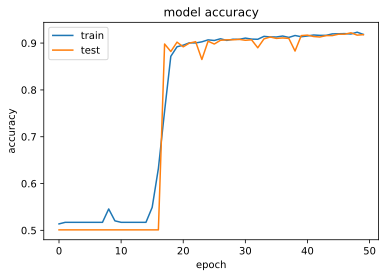

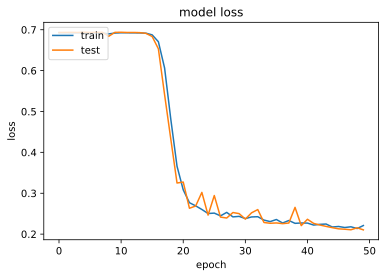

In [13]:
# Plot accuracy and loss vs. epoch

# list all data in history
print(history.history.keys())

plt.cla(); plt.clf()

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [14]:
# plot ROC curve
from sklearn.metrics import roc_curve, auc
y_pred = model_nn.predict(X_te)
fpr_nn, tpr_nn, thres_nn = roc_curve(y_te_onehot[:,0], y_pred[:,0])
auc_nn = auc(fpr_nn, tpr_nn)
print("Area under curve: {}".format(auc_nn))

Area under curve: 0.97245619887


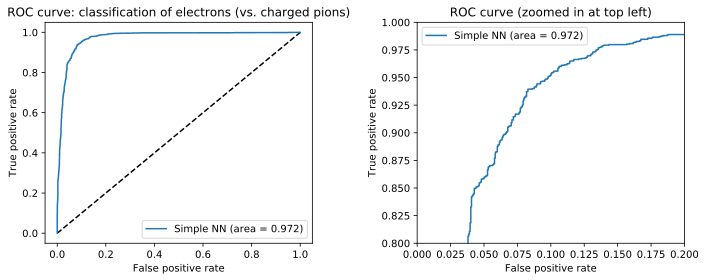

In [15]:
plt.cla(); plt.clf()
fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10,4))

ax[0].plot([0, 1], [0, 1], 'k--')
ax[0].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
ax[0].set_xlabel('False positive rate')
ax[0].set_ylabel('True positive rate')
ax[0].set_title('ROC curve: classification of electrons (vs. charged pions)')
ax[0].legend(loc='best')

# Zoom in view of the upper left corner.
ax[1].set_xlim(0, 0.2)
ax[1].set_ylim(0.8, 1)
ax[1].plot([0, 1], [0, 1], 'k--')
ax[1].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
ax[1].set_xlabel('False positive rate')
ax[1].set_ylabel('True positive rate')
ax[1].set_title('ROC curve (zoomed in at top left)')
ax[1].legend(loc='best')

plt.show()

## 2. Convolutional Neural Network

In [16]:
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# Train on pT = 100 GeV electron/pion samples

# include the EMB2 layer as a 2D image
layer = layers[1]
num_pixels = int(len_phi[1]*len_eta[1])

X = np.append(elec[layer], pion[layer], axis=0)
# reshape to be [samples][width][height][pixels]
#X = X.reshape(X.shape[0], 1, 128, 4)
X = X.reshape(X.shape[0], 1, 16, 16)

y = np.append(elec['label'], pion['label'], axis=0)

# split up into training and test datasets
test_size = 4000
validation_size = 1000
from sklearn.cross_validation import train_test_split
X_tr, X_te_vl, y_tr, y_te_vl, = train_test_split(X, y, test_size=test_size+validation_size, random_state=1)
X_te, X_vl, y_te, y_vl, = train_test_split(X_te_vl, y_te_vl, test_size=validation_size, random_state=1)

# normalize inputs from 0-255 to 0-1
X_tr = X_tr / 255
X_te = X_te / 255
X_vl = X_vl / 255

print (X_tr.shape)
print (y_tr.shape)

# one hot encode outputs
from keras.utils import np_utils
y_tr_onehot = np_utils.to_categorical(y_tr)
y_te_onehot = np_utils.to_categorical(y_te)
y_vl_onehot = np_utils.to_categorical(y_vl)
num_classes = y_te_onehot.shape[1]
print("y_train.shape: ",y_tr.shape)
print("y_train_onehot.shape: ",y_tr_onehot.shape)

(17709, 1, 16, 16)
(17709, 1)
('y_train.shape: ', (17709, 1))
('y_train_onehot.shape: ', (17709, 2))


In [17]:
# define a simple convolutional model
def baseline_ccn_model():
    # create model
    model = Sequential()
    model.add(Conv2D(32, (4, 4), input_shape=(1,16,16), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(2, kernel_initializer='normal', activation='softmax'))
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [18]:
# build the model
model_cnn_base = baseline_ccn_model()
model_cnn_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 13, 13)        544       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 6, 6)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 6, 6)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               147584    
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 258       
Total params: 148,386
Trainable params: 148,386
Non-trainable params: 0
_________________________________________________________________


In [19]:
# define a deep-ish convolutional model
def larger_cnn_model():
    # create model
    model = Sequential()
    model.add(Conv2D(32, (4, 4), input_shape=(1,16,16), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(16, (2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(2, kernel_initializer='normal', activation='softmax'))
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [20]:
# build the model
model_cnn_large = larger_cnn_model()
model_cnn_large.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 13, 13)        544       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 6, 6)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 5, 5)          2064      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 2, 2)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 2, 2)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               8320      
__________

In [21]:
# fit (train) the baseline cnn model
history_cnn_base = model_cnn_base.fit(X_tr, y_tr_onehot, validation_data=(X_vl, y_vl_onehot), epochs=20, batch_size=200, verbose=2)

# final evaluation of the model
scores_cnn_base = model_cnn_base.evaluate(X_te, y_te_onehot, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores_cnn_base[1]*100))

Train on 17709 samples, validate on 1000 samples
Epoch 1/20
 - 6s - loss: 0.6928 - acc: 0.5152 - val_loss: 0.6933 - val_acc: 0.5010
Epoch 2/20
 - 6s - loss: 0.6924 - acc: 0.5171 - val_loss: 0.6928 - val_acc: 0.5010
Epoch 3/20
 - 6s - loss: 0.6895 - acc: 0.5232 - val_loss: 0.6843 - val_acc: 0.5010
Epoch 4/20
 - 6s - loss: 0.6635 - acc: 0.6663 - val_loss: 0.6395 - val_acc: 0.5010
Epoch 5/20
 - 6s - loss: 0.5628 - acc: 0.8292 - val_loss: 0.4903 - val_acc: 0.8520
Epoch 6/20
 - 6s - loss: 0.4404 - acc: 0.8653 - val_loss: 0.3986 - val_acc: 0.8620
Epoch 7/20
 - 6s - loss: 0.3887 - acc: 0.8673 - val_loss: 0.3678 - val_acc: 0.8850
Epoch 8/20
 - 6s - loss: 0.3669 - acc: 0.8757 - val_loss: 0.3487 - val_acc: 0.8770
Epoch 9/20
 - 6s - loss: 0.3589 - acc: 0.8753 - val_loss: 0.3386 - val_acc: 0.8850
Epoch 10/20
 - 6s - loss: 0.3550 - acc: 0.8755 - val_loss: 0.3386 - val_acc: 0.8900
Epoch 11/20
 - 6s - loss: 0.3498 - acc: 0.8769 - val_loss: 0.3347 - val_acc: 0.8860
Epoch 12/20
 - 6s - loss: 0.3450 - a

In [22]:
# fit (train) the larger cnn model
history_cnn_large = model_cnn_large.fit(X_tr, y_tr_onehot, validation_data=(X_vl, y_vl_onehot), epochs=20, batch_size=200, verbose=2)

# final evaluation of the model
scores_cnn_large = model_cnn_large.evaluate(X_te, y_te_onehot, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores_cnn_large[1]*100))

Train on 17709 samples, validate on 1000 samples
Epoch 1/20
 - 6s - loss: 0.6927 - acc: 0.5152 - val_loss: 0.6935 - val_acc: 0.5010
Epoch 2/20
 - 5s - loss: 0.6926 - acc: 0.5171 - val_loss: 0.6934 - val_acc: 0.5010
Epoch 3/20
 - 5s - loss: 0.6927 - acc: 0.5171 - val_loss: 0.6935 - val_acc: 0.5010
Epoch 4/20
 - 5s - loss: 0.6925 - acc: 0.5171 - val_loss: 0.6937 - val_acc: 0.5010
Epoch 5/20
 - 5s - loss: 0.6905 - acc: 0.5249 - val_loss: 0.6806 - val_acc: 0.5010
Epoch 6/20
 - 5s - loss: 0.5521 - acc: 0.7517 - val_loss: 0.3751 - val_acc: 0.8650
Epoch 7/20
 - 5s - loss: 0.3695 - acc: 0.8655 - val_loss: 0.3277 - val_acc: 0.8930
Epoch 8/20
 - 5s - loss: 0.3573 - acc: 0.8652 - val_loss: 0.3187 - val_acc: 0.8950
Epoch 9/20
 - 5s - loss: 0.3335 - acc: 0.8750 - val_loss: 0.3198 - val_acc: 0.8830
Epoch 10/20
 - 5s - loss: 0.3240 - acc: 0.8796 - val_loss: 0.3064 - val_acc: 0.8900
Epoch 11/20
 - 5s - loss: 0.3154 - acc: 0.8822 - val_loss: 0.3129 - val_acc: 0.8800
Epoch 12/20
 - 5s - loss: 0.3136 - a

['acc', 'loss', 'val_acc', 'val_loss']


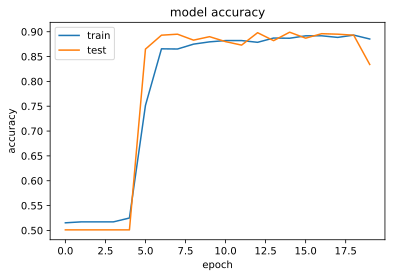

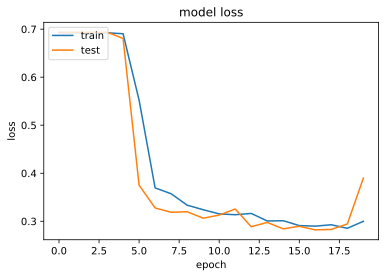

In [23]:
# Plot accuracy and loss vs. epoch

# list all data in history
print(history_cnn_large.history.keys())

# summarize history for accuracy
plt.plot(history_cnn_large.history['acc'])
plt.plot(history_cnn_large.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history_cnn_large.history['loss'])
plt.plot(history_cnn_large.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 3. Train multiple ConvNets on the images and merge

Next, try to train convolutional nets on multiple input layers, then merge and flatten the layers.

In [24]:
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# Train on pT = 100 GeV electron/pion samples

#X0 = np.append(elec['EMB1'], pion['EMB1'], axis=0)

# flatten first layer (for now...)
X0 = np.append(elec['EMB1'].reshape((len(elec['EMB1']),512)),
              pion['EMB1'].reshape((len(pion['EMB1']),512)), axis=0)

X1 = np.append(elec['EMB2'], pion['EMB2'], axis=0)
X2 = np.append(elec['EMB3'], pion['EMB3'], axis=0)

# reshape to be [samples][width][height][pixels]
#X0 = X0.reshape(X0.shape[0], 1, 128, 4)
X1 = X1.reshape(X1.shape[0], 1, 16, 16)
X2 = X2.reshape(X2.shape[0], 1, 8, 16)

y = np.append(elec['label'], pion['label'], axis=0)

print X0.shape
print X1.shape
print X2.shape
print y.shape

# split up into training and test datasets
test_size = 4000
validation_size = 1000
from sklearn.cross_validation import train_test_split
X0_tr, X0_te_vl, X1_tr, X1_te_vl, X2_tr, X2_te_vl, y_tr, y_te_vl, = train_test_split(X0, X1, X2, y, test_size=test_size+validation_size, random_state=1)
X0_te, X0_vl, X1_te, X1_vl, X2_te, X2_vl, y_te, y_vl, = train_test_split(X0_te_vl, X1_te_vl, X2_te_vl, y_te_vl, test_size=validation_size, random_state=1)

# normalize inputs from 0-255 to 0-1
X0_tr = X0_tr / 255
X0_te = X0_te / 255
X0_vl = X0_vl / 255
X1_tr = X1_tr / 255
X1_te = X1_te / 255
X1_vl = X1_vl / 255
X2_tr = X2_tr / 255
X2_te = X2_te / 255
X2_vl = X2_vl / 255

print (X0_tr.shape)
print (y_tr.shape)

# one hot encode outputs
from keras.utils import np_utils
y_tr_onehot = np_utils.to_categorical(y_tr)
y_te_onehot = np_utils.to_categorical(y_te)
y_vl_onehot = np_utils.to_categorical(y_vl)
num_classes = y_te_onehot.shape[1]
print("y_train.shape: ",y_tr.shape)
print("y_train_onehot.shape: ",y_tr_onehot.shape)

(22709, 512)
(22709, 1, 16, 16)
(22709, 1, 8, 16)
(22709, 1)
(17709, 512)
(17709, 1)
('y_train.shape: ', (17709, 1))
('y_train_onehot.shape: ', (17709, 2))


In [25]:
# define convolutional model for multiple input images

from keras.models import Model
from keras.layers import concatenate
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

# create model

def merged_model():
    
    # EMB1 image (flat, fully-connected)
    input1 = Input(shape=(512,), name='input1')
    x1 = Dense(512, activation='relu')(input1)
    x1 = Dense(256, activation='relu')(x1) 
    x1 = Dense(128, activation='relu')(x1) 

    # EMB2 image (convolutional)
    input2 = Input(shape=(1,16,16), name='input2')
    x2 = Conv2D(32, (4, 4), activation='relu')(input2)
    x2 = MaxPooling2D(pool_size=(2, 2))(x2)
    x2 = Dropout(0.2)(x2)
    x2 = Flatten()(x2)
    x2 = Dense(128, activation='relu')(x2)

    # concatenate outputs from the two networks above
    x = concatenate([x1, x2]) 
    x = Dense(50, activation='relu')(x)    

    # final output
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs = [input1, input2], outputs = [output])
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    return model

In [26]:
# build the model
model_merged = merged_model()
model_merged.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input2 (InputLayer)             (None, 1, 16, 16)    0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 32, 13, 13)   544         input2[0][0]                     
__________________________________________________________________________________________________
input1 (InputLayer)             (None, 512)          0                                            
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 32, 6, 6)     0           conv2d_4[0][0]                   
__________________________________________________________________________________________________
dense_10 (

In [27]:
# fit (train) the merged model
history = model_merged.fit([X0_tr, X1_tr], [y_tr_onehot], validation_data=([X0_vl, X1_vl], [y_vl_onehot]), epochs=100, batch_size=200, verbose=2)

# final evaluation of the model
scores = model_merged.evaluate([X0_te, X1_te], [y_te_onehot], verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Train on 17709 samples, validate on 1000 samples
Epoch 1/100
 - 7s - loss: 0.6928 - acc: 0.5152 - val_loss: 0.6932 - val_acc: 0.5010
Epoch 2/100
 - 6s - loss: 0.6926 - acc: 0.5171 - val_loss: 0.6932 - val_acc: 0.5010
Epoch 3/100
 - 6s - loss: 0.6915 - acc: 0.5210 - val_loss: 0.6887 - val_acc: 0.8380
Epoch 4/100
 - 6s - loss: 0.6561 - acc: 0.6667 - val_loss: 0.5678 - val_acc: 0.8340
Epoch 5/100
 - 7s - loss: 0.4460 - acc: 0.8396 - val_loss: 0.3693 - val_acc: 0.8620
Epoch 6/100
 - 6s - loss: 0.3635 - acc: 0.8604 - val_loss: 0.3553 - val_acc: 0.8630
Epoch 7/100
 - 6s - loss: 0.3407 - acc: 0.8731 - val_loss: 0.3197 - val_acc: 0.8860
Epoch 8/100
 - 6s - loss: 0.3309 - acc: 0.8766 - val_loss: 0.3291 - val_acc: 0.8740
Epoch 9/100
 - 7s - loss: 0.3293 - acc: 0.8780 - val_loss: 0.3331 - val_acc: 0.8700
Epoch 10/100
 - 7s - loss: 0.3180 - acc: 0.8835 - val_loss: 0.3057 - val_acc: 0.8870
Epoch 11/100
 - 7s - loss: 0.3306 - acc: 0.8727 - val_loss: 0.3168 - val_acc: 0.8790
Epoch 12/100
 - 7s - loss

['acc', 'loss', 'val_acc', 'val_loss']


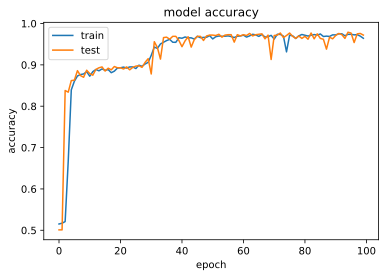

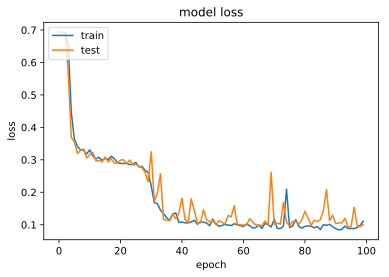

In [28]:
# Plot accuracy and loss vs. epoch

# list all data in history
print(history.history.keys())

plt.cla(); plt.clf()

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#plt.savefig('merged_cnn_accuracy.pdf')

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()
#plt.savefig('merged_cnn_loss.pdf')

In [29]:
# plot ROC curve
from sklearn.metrics import roc_curve, auc
y_pred = model_merged.predict([X0_te, X1_te])
fpr_merge, tpr_merge, thres_merge = roc_curve(y_te_onehot[:,0], y_pred[:,0])
auc_merge = auc(fpr_merge, tpr_merge)
print("Area under curve: {}".format(auc_merge))

Area under curve: 0.994356012457


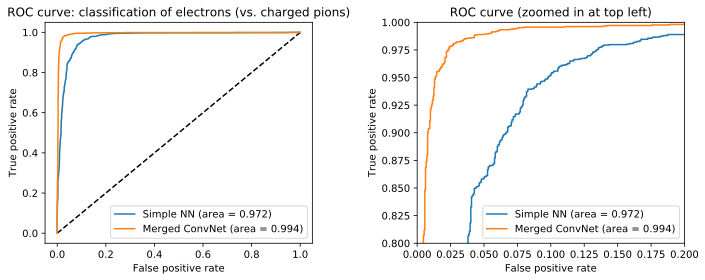

In [30]:
plt.cla(); plt.clf()
fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10,4))

ax[0].plot([0, 1], [0, 1], 'k--')
ax[0].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
ax[0].plot(fpr_merge, tpr_merge, label='Merged ConvNet (area = {:.3f})'.format(auc_merge))
ax[0].set_xlabel('False positive rate')
ax[0].set_ylabel('True positive rate')
ax[0].set_title('ROC curve: classification of electrons (vs. charged pions)')
ax[0].legend(loc='best')

# Zoom in view of the upper left corner.
ax[1].set_xlim(0, 0.2)
ax[1].set_ylim(0.8, 1)
ax[1].plot([0, 1], [0, 1], 'k--')
ax[1].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
ax[1].plot(fpr_merge, tpr_merge, label='Merged ConvNet (area = {:.3f})'.format(auc_merge))
ax[1].set_xlabel('False positive rate')
ax[1].set_ylabel('True positive rate')
ax[1].set_title('ROC curve (zoomed in at top left)')
ax[1].legend(loc='best')

plt.show()
#plt.savefig('ROC_curve_final.pdf')

Next: Include all input images (calorimeter layers)

Visualize the filters: 
 https://hackernoon.com/visualizing-parts-of-convolutional-neural-networks-using-keras-and-cats-5cc01b214e59